## Import libraries

In [1]:
! pip install impyute

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from impyute.imputation.cs import mice
from scipy.spatial.distance import cdist
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import QuantileTransformer

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, Add
from tensorflow.keras.layers import AveragePooling1D
from tensorflow.keras.layers import Activation, Input
from tensorflow.keras.layers import Embedding, Conv1D
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.layers import Flatten, Dense, Dropout

np.random.seed(42)
tf.random.set_seed(42)

## Load source datasets

In [3]:
train = pd.read_csv("../input/mh-dare-in-reality/train.csv")
train.columns = train.columns.str.replace(' ','')
print(f"train: {train.shape}")
train.head()

train: (10276, 25)


,NUMBER,DRIVER_NUMBER,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,...,S1_LARGE,S2_LARGE,S3_LARGE,DRIVER_NAME,PIT_TIME,GROUP,TEAM,POWER,LOCATION,EVENT
0,10,1,1,92,0,NaN,05:43.3,0,35.427,0,...,05:43.3,00:35.4,00:43.3,SB,05:14.7,NaN,JR,NaN,Location 2,Free Practice 2
1,10,1,2,87,2,NaN,25.674,2,33.399,2,...,00:25.7,00:33.4,00:41.9,SB,NaN,NaN,JR,NaN,Location 2,Free Practice 2
2,10,1,3,73,0,B,28.129,0,34.091,0,...,00:28.1,00:34.1,00:57.2,SB,NaN,NaN,JR,NaN,Location 2,Free Practice 2
3,11,1,1,73,0,NaN,01:05.0,0,38.416,0,...,01:05.0,00:38.4,00:56.8,LGRA,00:33.0,NaN,AD,NaN,Location 2,Free Practice 2
4,11,1,2,73,0,NaN,28.013,0,36.743,0,...,00:28.0,00:36.7,00:44.7,LGRA,NaN,NaN,AD,NaN,Location 2,Free Practice 2


In [4]:
test = pd.read_csv("../input/mh-dare-in-reality/test.csv")
test.columns = test.columns.str.replace(' ','')
print(f"test: {test.shape}")
test.head()

test: (420, 25)


,NUMBER,DRIVER_NUMBER,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,...,S1_LARGE,S2_LARGE,S3_LARGE,DRIVER_NAME,PIT_TIME,GROUP,TEAM,POWER,LOCATION,EVENT
0,10,1,1,NaN,0,NaN,01:10.2,0,35.433,0,...,01:10.2,00:35.4,00:30.7,SB,00:47.0,1.0,JR,NaN,Location 7,Qualifying Group 1
1,10,1,2,NaN,0,NaN,27.667,0,33.68,0,...,00:27.7,00:33.7,00:37.8,SB,NaN,1.0,JR,250.0,Location 7,Qualifying Group 1
2,10,1,3,NaN,2,NaN,24.688,2,29.309,2,...,00:24.7,00:29.3,00:27.1,SB,NaN,1.0,JR,250.0,Location 7,Qualifying Group 1
3,13,1,1,NaN,0,NaN,01:09.1,0,35.705,0,...,01:09.1,00:35.7,00:30.5,ACO,00:44.7,1.0,DSo,NaN,Location 7,Qualifying Group 1
4,13,1,2,NaN,0,NaN,28.401,0,33.693,0,...,00:28.4,00:33.7,00:36.0,ACO,NaN,1.0,DSo,250.0,Location 7,Qualifying Group 1


In [5]:
train_weather = pd.read_csv("../input/mh-dare-in-reality/train_weather.csv")
print(f"train_weather: {train_weather.shape}")

test_weather = pd.read_csv("../input/mh-dare-in-reality/test_weather.csv").rename(columns={'EVENTS':'EVENT'})
print(f"test_weather: {test_weather.shape}")

weather_data = train_weather.append(test_weather, ignore_index=True)
weather_data.columns = weather_data.columns.str.replace(' ','')
print(f"weather_data: {weather_data.shape}")
weather_data.head()

train_weather: (914, 11)
test_weather: (167, 11)
weather_data: (1081, 11)


,TIME_UTC_SECONDS,TIME_UTC_STR,AIR_TEMP,TRACK_TEMP,HUMIDITY,PRESSURE,WIND_SPEED,WIND_DIRECTION,RAIN,LOCATION,EVENT
0,1618042506,10/04/21 8:15,15,18.4,60,1018.05,2.12187,165,-1,Location 2,Free Practice 2
1,1618042567,10/04/21 8:16,15.0556,18.4,60,1018.12,1.06093,177,-1,Location 2,Free Practice 2
2,1618042632,10/04/21 8:17,15.0556,18.5,60,1018.12,2.12187,157,-1,Location 2,Free Practice 2
3,1618042697,10/04/21 8:18,15.0556,18.5,60,1018.08,2.12187,163,-1,Location 2,Free Practice 2
4,1618042762,10/04/21 8:19,15.1111,18.5,60,1018.15,3.1828,149,-1,Location 2,Free Practice 2


In [6]:
lap_time = train['LAP_TIME'].values

P_MIN = np.min(lap_time)
P_MAX = np.max(lap_time)
P_STEP = (lap_time[1] - lap_time[0])
print('Min lap_time: {}'.format(P_MIN))
print('Max lap_time: {}'.format(P_MAX))
print('lap_time step: {}'.format(P_STEP))
print('Unique values:  {}'.format(np.unique(lap_time).shape[0]))

Min lap_time: 0
Max lap_time: 199
lap_time step: -5
Unique values:  161


## Data Preprocessing

In [7]:
def convert2sec(time):
    if type(time) != str:
        return time

    parts = [float(p) for p in time.split(':')]
    parts = [p * (60 ** i) for i, p in enumerate(reversed(parts))]
    return sum(parts)

In [8]:
time_cols = ['ELAPSED', 'S1', 'S2', 'S3', 'S1_LARGE', 'S2_LARGE', 'S3_LARGE', 'HOUR','PIT_TIME']

for col in tqdm(time_cols):
    train[col] = train[col].apply(convert2sec)
    test[col] = test[col].apply(convert2sec)

100%|██████████| 9/9 [00:00<00:00, 46.98it/s]


In [9]:
le_cols = ['DRIVER_NAME', 'TEAM']

for col in tqdm(le_cols):
    le = LabelEncoder().fit(train[col].append(test[col]))
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])

100%|██████████| 2/2 [00:00<00:00, 238.83it/s]


In [10]:
train['CROSSING_FINISH_LINE_IN_PIT'] = train['CROSSING_FINISH_LINE_IN_PIT'].apply(lambda x: 0 if pd.isnull(x) else 1)
test['CROSSING_FINISH_LINE_IN_PIT'] = test['CROSSING_FINISH_LINE_IN_PIT'].apply(lambda x: 0 if pd.isnull(x) else 1)

train['GROUP'].fillna(5, inplace=True)
test['GROUP'].fillna(5, inplace=True)

train['POWER'] = train['POWER'].apply(lambda x: 0 if pd.isnull(x) else 1 if x==235 else 2)
test['POWER'] = test['POWER'].apply(lambda x: 0 if pd.isnull(x) else 1 if x==235 else 2)

train['LOCATION'] = train['LOCATION'].apply(lambda x: int(x[-1]))
test['LOCATION'] = test['LOCATION'].apply(lambda x: int(x[-1]))

train['EVENT_TYPE'] = train['EVENT'].apply(lambda x: 1 if 'Free Practice' in x else 0)
test['EVENT_TYPE'] = test['EVENT'].apply(lambda x: 1 if 'Free Practice' in x else 0)

train['EVENT'] = train['EVENT'].apply(lambda x: int(x[-1]))
test['EVENT'] = test['EVENT'].apply(lambda x: int(x[-1]))

train.head()

,NUMBER,DRIVER_NUMBER,LAP_NUMBER,LAP_TIME,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,...,S2_LARGE,S3_LARGE,DRIVER_NAME,PIT_TIME,GROUP,TEAM,POWER,LOCATION,EVENT,EVENT_TYPE
0,10,1,1,92,0,0,343.300,0,35.427,0,...,35.4,43.3,19,314.7,5.0,12,0,2,2,1
1,10,1,2,87,2,0,25.674,2,33.399,2,...,33.4,41.9,19,NaN,5.0,12,0,2,2,1
2,10,1,3,73,0,1,28.129,0,34.091,0,...,34.1,57.2,19,NaN,5.0,12,0,2,2,1
3,11,1,1,73,0,0,65.000,0,38.416,0,...,38.4,56.8,7,33.0,5.0,0,0,2,2,1
4,11,1,2,73,0,0,28.013,0,36.743,0,...,36.7,44.7,7,NaN,5.0,0,0,2,2,1


In [11]:
train_y = np.log1p(train['LAP_TIME']).values
train.drop(['DRIVER_NUMBER','LAP_TIME'], axis=1, inplace=True)
test.drop(['DRIVER_NUMBER','LAP_TIME'], axis=1, inplace=True)
print(f"train: {train.shape} \ntest: {test.shape}")

train: (10276, 24) 
test: (420, 24)


In [12]:
train = pd.DataFrame(mice(train.values), columns=train.columns, index=train.index)
test = pd.DataFrame(mice(test.values), columns=test.columns, index=test.index)

## Data Preprocessing (Weather Data)

In [13]:
def air_temp_prcs(x):
    tmp = x.replace(',','')
    if len(tmp) < 4:
        return float(tmp)/10.0
    elif len(tmp) == 4:
        return float(tmp)/100.0
    elif len(tmp) == 5:
        return float(tmp) / 1000.0
    elif len(tmp) > 5:
        return float(tmp) / 10000.0
    
    
def pressure_prcs(x):
    tmp = x.split(',')
    if len(tmp) < 3:
        return x.replace(',','.')
    else:
        return float(x.replace(',',''))/1000.0
    

def wind_speed_prcs(x):
    tmp = x.split(',')
    if len(tmp) < 3:
        return x.replace(',','.')
    else:
        return float(x.replace(',',''))/100000.0

In [14]:
train_weather['AIR_TEMP'] = train_weather['AIR_TEMP'].apply(lambda x: air_temp_prcs(x) if ',' in x else x)
train_weather['AIR_TEMP'] = train_weather['AIR_TEMP'].astype('float')

train_weather['PRESSURE'] = train_weather['PRESSURE'].apply(lambda x: pressure_prcs(x) if ',' in x else x)
train_weather['PRESSURE'] = train_weather['PRESSURE'].astype('float')

train_weather['WIND_SPEED'] = train_weather['WIND_SPEED'].apply(lambda x: wind_speed_prcs(x) if ',' in x else x)
train_weather['WIND_SPEED'] = train_weather['WIND_SPEED'].astype('float')

train_weather['TRACK_TEMP'] = train_weather['TRACK_TEMP'].apply(lambda x: float(x.replace(',','.')))
train_weather['HUMIDITY'] = train_weather['HUMIDITY'].apply(lambda x: float(x.replace(',','.')))

train_weather['RAIN'] = train_weather['RAIN'].apply(lambda x: float(x.replace(',','.')) if ',' in str(x) else x)
train_weather['RAIN'] = train_weather['RAIN'].astype('float')

train_weather.head()

,TIME_UTC_SECONDS,TIME_UTC_STR,AIR_TEMP,TRACK_TEMP,HUMIDITY,PRESSURE,WIND_SPEED,WIND_DIRECTION,RAIN,LOCATION,EVENT
0,1618042506,10/04/21 8:15,15.0000,18.4,60.0,1018.05,2.12187,165,-1.0,Location 2,Free Practice 2
1,1618042567,10/04/21 8:16,15.0556,18.4,60.0,1018.12,1.06093,177,-1.0,Location 2,Free Practice 2
2,1618042632,10/04/21 8:17,15.0556,18.5,60.0,1018.12,2.12187,157,-1.0,Location 2,Free Practice 2
3,1618042697,10/04/21 8:18,15.0556,18.5,60.0,1018.08,2.12187,163,-1.0,Location 2,Free Practice 2
4,1618042762,10/04/21 8:19,15.1111,18.5,60.0,1018.15,3.18280,149,-1.0,Location 2,Free Practice 2


In [15]:
df = train_weather.groupby(['LOCATION','EVENT']).agg({
    'AIR_TEMP': ['mean','std'],
    'TRACK_TEMP': ['mean','std'],
    'HUMIDITY': ['mean','std'],
    'PRESSURE': ['mean','std'],
    'WIND_SPEED': ['mean','std'],
    'WIND_DIRECTION': ['mean','std'],
    'RAIN': ['mean','std']
})

df.columns = ['_'.join(x) for x in df.columns]
df.reset_index(inplace=True)

df['LOCATION'] = df['LOCATION'].apply(lambda x: int(x[-1]))
df['EVENT_TYPE'] = df['EVENT'].apply(lambda x: 1 if 'Free Practice' in x else 0)
df['EVENT'] = df['EVENT'].apply(lambda x: int(x[-1]))
df.head()

,LOCATION,EVENT,AIR_TEMP_mean,AIR_TEMP_std,TRACK_TEMP_mean,TRACK_TEMP_std,HUMIDITY_mean,HUMIDITY_std,PRESSURE_mean,PRESSURE_std,WIND_SPEED_mean,WIND_SPEED_std,WIND_DIRECTION_mean,WIND_DIRECTION_std,RAIN_mean,RAIN_std,EVENT_TYPE
0,1,1,17.538364,0.166663,19.564286,0.357376,45.000000,0.000000,937.023571,0.232658,4.723681,2.237762,306.476190,23.043160,-1.0,0.0,1
1,1,2,20.851193,0.130115,34.039286,0.363460,34.321429,0.611832,937.238750,0.067931,3.523816,1.938146,293.357143,20.843712,-1.0,0.0,1
2,1,3,22.498669,0.316774,34.259524,0.528717,30.595238,0.857094,937.191238,0.158998,3.081760,2.053611,234.571429,123.864234,-1.0,0.0,1
3,1,1,22.277763,0.594636,28.625000,0.391882,31.500000,1.603567,937.200125,0.086964,2.387101,1.359844,265.375000,107.982720,-1.0,0.0,0
4,1,2,22.349200,0.574394,27.714286,0.376070,31.714286,1.603567,937.144571,0.158262,1.818743,1.180499,221.714286,122.713371,-1.0,0.0,0


In [16]:
train = pd.merge(
    train,
    df,
    how='left',
    on=['LOCATION','EVENT_TYPE','EVENT'],
    sort=False
)

train.fillna(-1, inplace=True)
train.head()

,NUMBER,LAP_NUMBER,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,S3,S3_IMPROVEMENT,...,HUMIDITY_mean,HUMIDITY_std,PRESSURE_mean,PRESSURE_std,WIND_SPEED_mean,WIND_SPEED_std,WIND_DIRECTION_mean,WIND_DIRECTION_std,RAIN_mean,RAIN_std
0,10.0,1.0,0.0,0.0,343.300,0.0,35.427,0.0,43.313,0.0,...,60.432432,0.502247,1018.215135,0.08614,3.584237,1.860442,148.0,23.558438,-1.0,0.0
1,10.0,2.0,2.0,0.0,25.674,2.0,33.399,2.0,41.922,2.0,...,60.432432,0.502247,1018.215135,0.08614,3.584237,1.860442,148.0,23.558438,-1.0,0.0
2,10.0,3.0,0.0,1.0,28.129,0.0,34.091,0.0,57.248,0.0,...,60.432432,0.502247,1018.215135,0.08614,3.584237,1.860442,148.0,23.558438,-1.0,0.0
3,11.0,1.0,0.0,0.0,65.000,0.0,38.416,0.0,56.833,0.0,...,60.432432,0.502247,1018.215135,0.08614,3.584237,1.860442,148.0,23.558438,-1.0,0.0
4,11.0,2.0,0.0,0.0,28.013,0.0,36.743,0.0,44.716,0.0,...,60.432432,0.502247,1018.215135,0.08614,3.584237,1.860442,148.0,23.558438,-1.0,0.0


In [17]:
test = pd.merge(
    test,
    df,
    how='left',
    on=['LOCATION','EVENT_TYPE','EVENT'],
    sort=False
)

test.fillna(-1, inplace=True)
test.head()

,NUMBER,LAP_NUMBER,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,S3,S3_IMPROVEMENT,...,HUMIDITY_mean,HUMIDITY_std,PRESSURE_mean,PRESSURE_std,WIND_SPEED_mean,WIND_SPEED_std,WIND_DIRECTION_mean,WIND_DIRECTION_std,RAIN_mean,RAIN_std
0,10.0,1.0,0.0,0.0,70.200,0.0,35.433,0.0,30.693,0.0,...,82.58375,2.729359,1007.38625,0.696418,9.73375,5.979928,221.25,143.274711,0.0,0.0
1,10.0,2.0,0.0,0.0,27.667,0.0,33.680,0.0,37.767,0.0,...,82.58375,2.729359,1007.38625,0.696418,9.73375,5.979928,221.25,143.274711,0.0,0.0
2,10.0,3.0,2.0,0.0,24.688,2.0,29.309,2.0,27.111,2.0,...,82.58375,2.729359,1007.38625,0.696418,9.73375,5.979928,221.25,143.274711,0.0,0.0
3,13.0,1.0,0.0,0.0,69.100,0.0,35.705,0.0,30.451,0.0,...,82.58375,2.729359,1007.38625,0.696418,9.73375,5.979928,221.25,143.274711,0.0,0.0
4,13.0,2.0,0.0,0.0,28.401,0.0,33.693,0.0,35.958,0.0,...,82.58375,2.729359,1007.38625,0.696418,9.73375,5.979928,221.25,143.274711,0.0,0.0


In [18]:
train[train.isin([np.nan, np.inf, -np.inf]).any(1)].head()

,NUMBER,LAP_NUMBER,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,S3,S3_IMPROVEMENT,...,HUMIDITY_mean,HUMIDITY_std,PRESSURE_mean,PRESSURE_std,WIND_SPEED_mean,WIND_SPEED_std,WIND_DIRECTION_mean,WIND_DIRECTION_std,RAIN_mean,RAIN_std


In [19]:
test[test.isin([np.nan, np.inf, -np.inf]).any(1)].head()

,NUMBER,LAP_NUMBER,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,S3,S3_IMPROVEMENT,...,HUMIDITY_mean,HUMIDITY_std,PRESSURE_mean,PRESSURE_std,WIND_SPEED_mean,WIND_SPEED_std,WIND_DIRECTION_mean,WIND_DIRECTION_std,RAIN_mean,RAIN_std


## Feature Engineering

In [20]:
train['Inverse_NUMBER'] = 1/train['NUMBER']
train['Inverse_LAP_NUMBER'] = 1/train['LAP_NUMBER']
train['Mean_S'] = train[['S1','S2','S3']].mean(axis=1)
train['Std_S'] = train[['S1','S2','S3']].std(axis=1)
train['Skew_S'] = train[['S1','S2','S3']].skew(axis=1)
train['Sum_S'] = train[['S1','S2','S3']].sum(axis=1)
train['Mean_S_Large'] = train[['S1_LARGE','S2_LARGE','S3_LARGE']].mean(axis=1)
train['Std_S_Large'] = train[['S1_LARGE','S2_LARGE','S3_LARGE']].std(axis=1)
train['Skew_S_Large'] = train[['S1_LARGE','S2_LARGE','S3_LARGE']].skew(axis=1)
train['Sum_S_Large'] = train[['S1_LARGE','S2_LARGE','S3_LARGE']].sum(axis=1)
train['S1_Large_Ratio'] = train['S1']/train['S1_LARGE']
train['S2_Large_Ratio'] = train['S2']/train['S2_LARGE']
train['S3_Large_Ratio'] = train['S3']/train['S3_LARGE']
train['sin_cos_ELAPSED'] = np.sin(train['ELAPSED']) * np.cos(train['ELAPSED'])
train['sin_cos_KPH'] = np.sin(train['KPH']) * np.cos(train['KPH'])
train['sin_cos_HOUR'] = np.sin(train['HOUR']) * np.cos(train['HOUR'])
train['sin_cos_PIT_TIME'] = np.sin(train['PIT_TIME']) * np.cos(train['PIT_TIME'])
train['Location*Event*Type)'] = train['LOCATION'] * train['EVENT'] * train['EVENT_TYPE']
train['S1_IMP*S2_IMP*S3_IMP'] = train['S1_IMPROVEMENT'] * train['S2_IMPROVEMENT'] * train['S3_IMPROVEMENT']
train['sin_S1*S1_LARGE'] = np.sin(train['S1']) * np.sin(train['S1_LARGE'])
train['sin_S2*S2_LARGE'] = np.sin(train['S2']) * np.sin(train['S2_LARGE'])
train['sin_S3*S3_LARGE'] = np.sin(train['S3']) * np.sin(train['S3_LARGE'])
train['cos_S1*S1_LARGE'] = np.cos(train['S1']) * np.cos(train['S1_LARGE'])
train['cos_S2*S2_LARGE'] = np.cos(train['S2']) * np.cos(train['S2_LARGE'])
train['cos_S3*S3_LARGE'] = np.cos(train['S3']) * np.cos(train['S3_LARGE'])
train['TEAM*DRIVER_NAME'] = train['TEAM'] * train['DRIVER_NAME']
train['EHP_Mean'] = train[['ELAPSED','HOUR','PIT_TIME']].mean(axis=1)
train['EHP_Std'] = train[['ELAPSED','HOUR','PIT_TIME']].std(axis=1)
train['EHP_Skew'] = train[['ELAPSED','HOUR','PIT_TIME']].skew(axis=1)
train['EHP_Sum'] = train[['ELAPSED','HOUR','PIT_TIME']].sum(axis=1)
train.head()

,NUMBER,LAP_NUMBER,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,S3,S3_IMPROVEMENT,...,sin_S2*S2_LARGE,sin_S3*S3_LARGE,cos_S1*S1_LARGE,cos_S2*S2_LARGE,cos_S3*S3_LARGE,TEAM*DRIVER_NAME,EHP_Mean,EHP_Std,EHP_Skew,EHP_Sum
0,10.0,1.0,0.0,0.0,343.300,0.0,35.427,0.0,43.313,0.0,...,0.570166,0.391232,0.419351,0.429469,0.608683,228.0,686.233333,553.197762,1.659031,2058.700000
1,10.0,2.0,2.0,0.0,25.674,2.0,33.399,2.0,41.922,2.0,...,0.839075,0.769609,0.722825,0.160925,0.230149,228.0,729.617727,616.607487,1.338583,2188.853181
2,10.0,3.0,0.0,1.0,28.129,0.0,34.091,0.0,57.248,0.0,...,0.198679,0.390245,0.974460,0.801281,0.608603,228.0,790.446284,690.079229,0.920413,2371.338852
3,11.0,1.0,0.0,0.0,65.000,0.0,38.416,0.0,56.833,0.0,...,0.423724,0.069763,0.316354,0.576148,0.929693,0.0,417.800000,559.958284,1.632044,1253.400000
4,11.0,2.0,0.0,0.0,28.013,0.0,36.743,0.0,44.716,0.0,...,0.687052,0.440382,0.929922,0.312024,0.559490,0.0,518.929013,568.706398,1.593331,1556.787039


In [21]:
test['Inverse_NUMBER'] = 1/test['NUMBER']
test['Inverse_LAP_NUMBER'] = 1/test['LAP_NUMBER']
test['Mean_S'] = test[['S1','S2','S3']].mean(axis=1)
test['Std_S'] = test[['S1','S2','S3']].std(axis=1)
test['Skew_S'] = test[['S1','S2','S3']].skew(axis=1)
test['Sum_S'] = test[['S1','S2','S3']].sum(axis=1)
test['Mean_S_Large'] = test[['S1_LARGE','S2_LARGE','S3_LARGE']].mean(axis=1)
test['Std_S_Large'] = test[['S1_LARGE','S2_LARGE','S3_LARGE']].std(axis=1)
test['Skew_S_Large'] = test[['S1_LARGE','S2_LARGE','S3_LARGE']].skew(axis=1)
test['Sum_S_Large'] = test[['S1_LARGE','S2_LARGE','S3_LARGE']].sum(axis=1)
test['S1_Large_Ratio'] = test['S1']/test['S1_LARGE']
test['S2_Large_Ratio'] = test['S2']/test['S2_LARGE']
test['S3_Large_Ratio'] = test['S3']/test['S3_LARGE']
test['sin_cos_ELAPSED'] = np.sin(test['ELAPSED']) * np.cos(test['ELAPSED'])
test['sin_cos_KPH'] = np.sin(test['KPH']) * np.cos(test['KPH'])
test['sin_cos_HOUR'] = np.sin(test['HOUR']) * np.cos(test['HOUR'])
test['sin_cos_PIT_TIME'] = np.sin(test['PIT_TIME']) * np.cos(test['PIT_TIME'])
test['Location*Event*Type)'] = test['LOCATION'] * test['EVENT'] * test['EVENT_TYPE']
test['S1_IMP*S2_IMP*S3_IMP'] = test['S1_IMPROVEMENT'] * test['S2_IMPROVEMENT'] * test['S3_IMPROVEMENT']
test['sin_S1*S1_LARGE'] = np.sin(test['S1']) * np.sin(test['S1_LARGE'])
test['sin_S2*S2_LARGE'] = np.sin(test['S2']) * np.sin(test['S2_LARGE'])
test['sin_S3*S3_LARGE'] = np.sin(test['S3']) * np.sin(test['S3_LARGE'])
test['cos_S1*S1_LARGE'] = np.cos(test['S1']) * np.cos(test['S1_LARGE'])
test['cos_S2*S2_LARGE'] = np.cos(test['S2']) * np.cos(test['S2_LARGE'])
test['cos_S3*S3_LARGE'] = np.cos(test['S3']) * np.cos(test['S3_LARGE'])
test['TEAM*DRIVER_NAME'] = test['TEAM'] * test['DRIVER_NAME']
test['EHP_Mean'] = test[['ELAPSED','HOUR','PIT_TIME']].mean(axis=1)
test['EHP_Std'] = test[['ELAPSED','HOUR','PIT_TIME']].std(axis=1)
test['EHP_Skew'] = test[['ELAPSED','HOUR','PIT_TIME']].skew(axis=1)
test['EHP_Sum'] = test[['ELAPSED','HOUR','PIT_TIME']].sum(axis=1)
test.head()

,NUMBER,LAP_NUMBER,LAP_IMPROVEMENT,CROSSING_FINISH_LINE_IN_PIT,S1,S1_IMPROVEMENT,S2,S2_IMPROVEMENT,S3,S3_IMPROVEMENT,...,sin_S2*S2_LARGE,sin_S3*S3_LARGE,cos_S1*S1_LARGE,cos_S2*S2_LARGE,cos_S3*S3_LARGE,TEAM*DRIVER_NAME,EHP_Mean,EHP_Std,EHP_Skew,EHP_Sum
0,10.0,1.0,0.0,0.0,70.200,0.0,35.433,0.0,30.693,0.0,...,0.573045,0.434207,0.218039,0.426410,0.565768,228.0,106.600000,51.615114,-1.732051,319.800000
1,10.0,2.0,0.0,0.0,27.667,0.0,33.680,0.0,37.767,0.0,...,0.581652,0.006832,0.689419,0.418148,0.992623,228.0,188.571912,81.281832,-1.732051,565.715737
2,10.0,3.0,2.0,0.0,24.688,2.0,29.309,2.0,27.111,2.0,...,0.735088,0.846913,0.819509,0.264872,0.153027,228.0,244.686714,124.557466,-1.732051,734.060141
3,13.0,1.0,0.0,0.0,69.100,0.0,35.705,0.0,30.451,0.0,...,0.829372,0.651956,0.999774,0.170615,0.346844,0.0,105.033333,52.250199,-1.732051,315.100000
4,13.0,2.0,0.0,0.0,28.401,0.0,33.693,0.0,35.958,0.0,...,0.575321,0.977429,0.984166,0.424655,0.021689,0.0,185.798381,82.275218,-1.732051,557.395143


In [22]:
temp = train.groupby(['S1_IMPROVEMENT']).agg({
    'S1': ['mean','std'], 
    'S2': ['mean','std'], 
    'S3': ['mean','std'],
    'S1_LARGE': ['mean','std'],
    'S2_LARGE': ['mean','std'],
    'S3_LARGE': ['mean','std']
})

temp.columns = ['s1_imp_'+'_'.join(x) for x in temp.columns]
train = pd.merge(train, temp, on=['S1_IMPROVEMENT'], how='left', sort=False)

In [23]:
temp = train.groupby(['S2_IMPROVEMENT']).agg({
    'S1': ['mean','std'], 
    'S2': ['mean','std'], 
    'S3': ['mean','std'],
    'S1_LARGE': ['mean','std'],
    'S2_LARGE': ['mean','std'],
    'S3_LARGE': ['mean','std']
})

temp.columns = ['s2_imp_'+'_'.join(x) for x in temp.columns]
train = pd.merge(train, temp, on=['S2_IMPROVEMENT'], how='left', sort=False)

In [24]:
temp = train.groupby(['S3_IMPROVEMENT']).agg({
    'S1': ['mean','std'], 
    'S2': ['mean','std'], 
    'S3': ['mean','std'],
    'S1_LARGE': ['mean','std'],
    'S2_LARGE': ['mean','std'],
    'S3_LARGE': ['mean','std']
})

temp.columns = ['s3_imp_'+'_'.join(x) for x in temp.columns]
train = pd.merge(train, temp, on=['S3_IMPROVEMENT'], how='left', sort=False)

In [25]:
temp = train.groupby(['LAP_NUMBER']).agg({
    'KPH': ['mean'], 
    'ELAPSED': ['mean'], 
    'HOUR': ['mean'],
    'PIT_TIME': ['mean']
})

temp.columns = ['lap_'+'_'.join(x) for x in temp.columns]
train = pd.merge(train, temp, on=['LAP_NUMBER'], how='left', sort=False)

In [26]:
temp = test.groupby(['S1_IMPROVEMENT']).agg({
    'S1': ['mean','std'], 
    'S2': ['mean','std'], 
    'S3': ['mean','std'],
    'S1_LARGE': ['mean','std'],
    'S2_LARGE': ['mean','std'],
    'S3_LARGE': ['mean','std']
})

temp.columns = ['s1_imp_'+'_'.join(x) for x in temp.columns]
test = pd.merge(test, temp, on=['S1_IMPROVEMENT'], how='left', sort=False)

In [27]:
temp = test.groupby(['S2_IMPROVEMENT']).agg({
    'S1': ['mean','std'], 
    'S2': ['mean','std'], 
    'S3': ['mean','std'],
    'S1_LARGE': ['mean','std'],
    'S2_LARGE': ['mean','std'],
    'S3_LARGE': ['mean','std']
})

temp.columns = ['s2_imp_'+'_'.join(x) for x in temp.columns]
test = pd.merge(test, temp, on=['S2_IMPROVEMENT'], how='left', sort=False)

In [28]:
temp = test.groupby(['S3_IMPROVEMENT']).agg({
    'S1': ['mean','std'], 
    'S2': ['mean','std'], 
    'S3': ['mean','std'],
    'S1_LARGE': ['mean','std'],
    'S2_LARGE': ['mean','std'],
    'S3_LARGE': ['mean','std']
})

temp.columns = ['s3_imp_'+'_'.join(x) for x in temp.columns]
test = pd.merge(test, temp, on=['S3_IMPROVEMENT'], how='left', sort=False)

In [29]:
temp = test.groupby(['LAP_NUMBER']).agg({
    'KPH': ['mean'], 
    'ELAPSED': ['mean'], 
    'HOUR': ['mean'],
    'PIT_TIME': ['mean']
})

temp.columns = ['lap_'+'_'.join(x) for x in temp.columns]
test = pd.merge(test, temp, on=['LAP_NUMBER'], how='left', sort=False)

## Feature Scaling

In [30]:
features = test.columns.tolist()
qt = QuantileTransformer(random_state=123, output_distribution='normal', n_quantiles=100)
train[features] = qt.fit_transform(train[features])
test[features] = qt.transform(test[features])

## KMeans

100%|██████████| 9/9 [00:29<00:00,  3.30s/it]


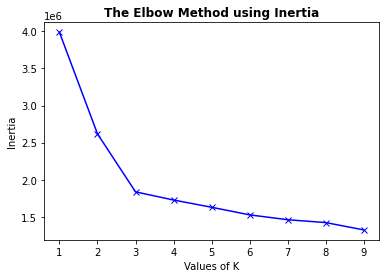

In [31]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in tqdm(K):
    kmeanModel = KMeans(n_clusters=k).fit(train)
    kmeanModel.fit(train)
 
    distortions.append(sum(np.min(cdist(train, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / train.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(train, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / train.shape[0]
    mapping2[k] = kmeanModel.inertia_
    
    
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia', fontweight='bold')
plt.show()

In [32]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)

kmeans.fit(train)
pred = kmeans.predict(train)
train['cluster'] = pred

pred = kmeans.predict(test)
test['cluster'] = pred

In [33]:
ds = np.load('../input/notebook8cc769eb0c/Meta_Features.npz', allow_pickle=True)
y_pred_meta_dnn, y_pred_final_dnn = ds['y_pred_meta_dnn'], ds['y_pred_final_dnn']

train['preds'] = np.mean(y_pred_meta_dnn, axis=1).ravel()
test['preds'] = np.mean(y_pred_final_dnn, axis=1).ravel()

In [34]:
features = test.columns.tolist()
scaler = MinMaxScaler().fit(train[features])
train[features] = scaler.transform(train[features])
test[features] = scaler.transform(test[features])

In [35]:
train['LAP_TIME'] = train_y.ravel()

Xtrain = train.loc[:, ~train.columns.isin(['LAP_TIME'])].copy()
Ytrain = train['LAP_TIME'].copy()
Ytrain_strat = pd.qcut(train['LAP_TIME'], q=15, labels=range(0,15))

print("Xtrain: {} \nYtrain: {} \nXtest: {}".format(Xtrain.shape, Ytrain.shape, test.shape))

Xtrain: (10276, 110) 
Ytrain: (10276,) 
Xtest: (420, 110)


## Keras DNN

In [36]:
def dnn_model(n_features):
    
    x_input = Input(shape=(n_features,))
    
    embed = Embedding(128, 8)(x_input)
    
    x1 = Conv1D(filters=12, kernel_size=3, 
                strides=1, padding='same', 
                kernel_regularizer=l2(0.0001),
                kernel_initializer='lecun_normal')(embed)
    x1 = LayerNormalization(epsilon=1e-5)(x1)
    x1 = Activation('relu')(x1)
    
    x1 = Flatten()(x1)
    
    x2 = Dense(units=512, kernel_initializer='lecun_normal', 
               kernel_regularizer=l2(0.0001))(x1)
    x2 = LayerNormalization(epsilon=1e-5)(x2)
    x2 = Activation('relu')(x2)
    x2 = Dropout(rate=0.5)(x2)
    
    x3 = Concatenate()([x1, x2])
    x3 = LayerNormalization(epsilon=1e-5)(x3)
    
    x4 = Dense(units=128, kernel_initializer='lecun_normal', 
               kernel_regularizer=l2(0.0001))(x3)
    x4 = LayerNormalization(epsilon=1e-5)(x4)
    x4 = Activation('relu')(x4)
    x4 = Dropout(rate=0.25)(x4)
    
    x = Concatenate()([x2, x4])
    x = LayerNormalization(epsilon=1e-5)(x)
    
    x = Dense(units=32, kernel_initializer='lecun_normal', 
              kernel_regularizer=l2(0.0001))(x)
    x = LayerNormalization(epsilon=1e-5)(x)
    x = Activation('relu')(x)
    x = Dropout(rate=0.15)(x)

    x_output = Dense(units=1, kernel_initializer='lecun_normal')(x)

    model = Model(inputs=x_input, outputs=x_output, 
                  name='DNN_Model')
    return model

In [37]:
model = dnn_model(Xtrain.shape[1])
model.summary()


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Model: "DNN_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 110)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 110, 8)       1024        input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 110, 12)      300         embedding[0][0]                  
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 110, 12)      24          conv1d[0][0]                     
__________________________________________________________________________________________

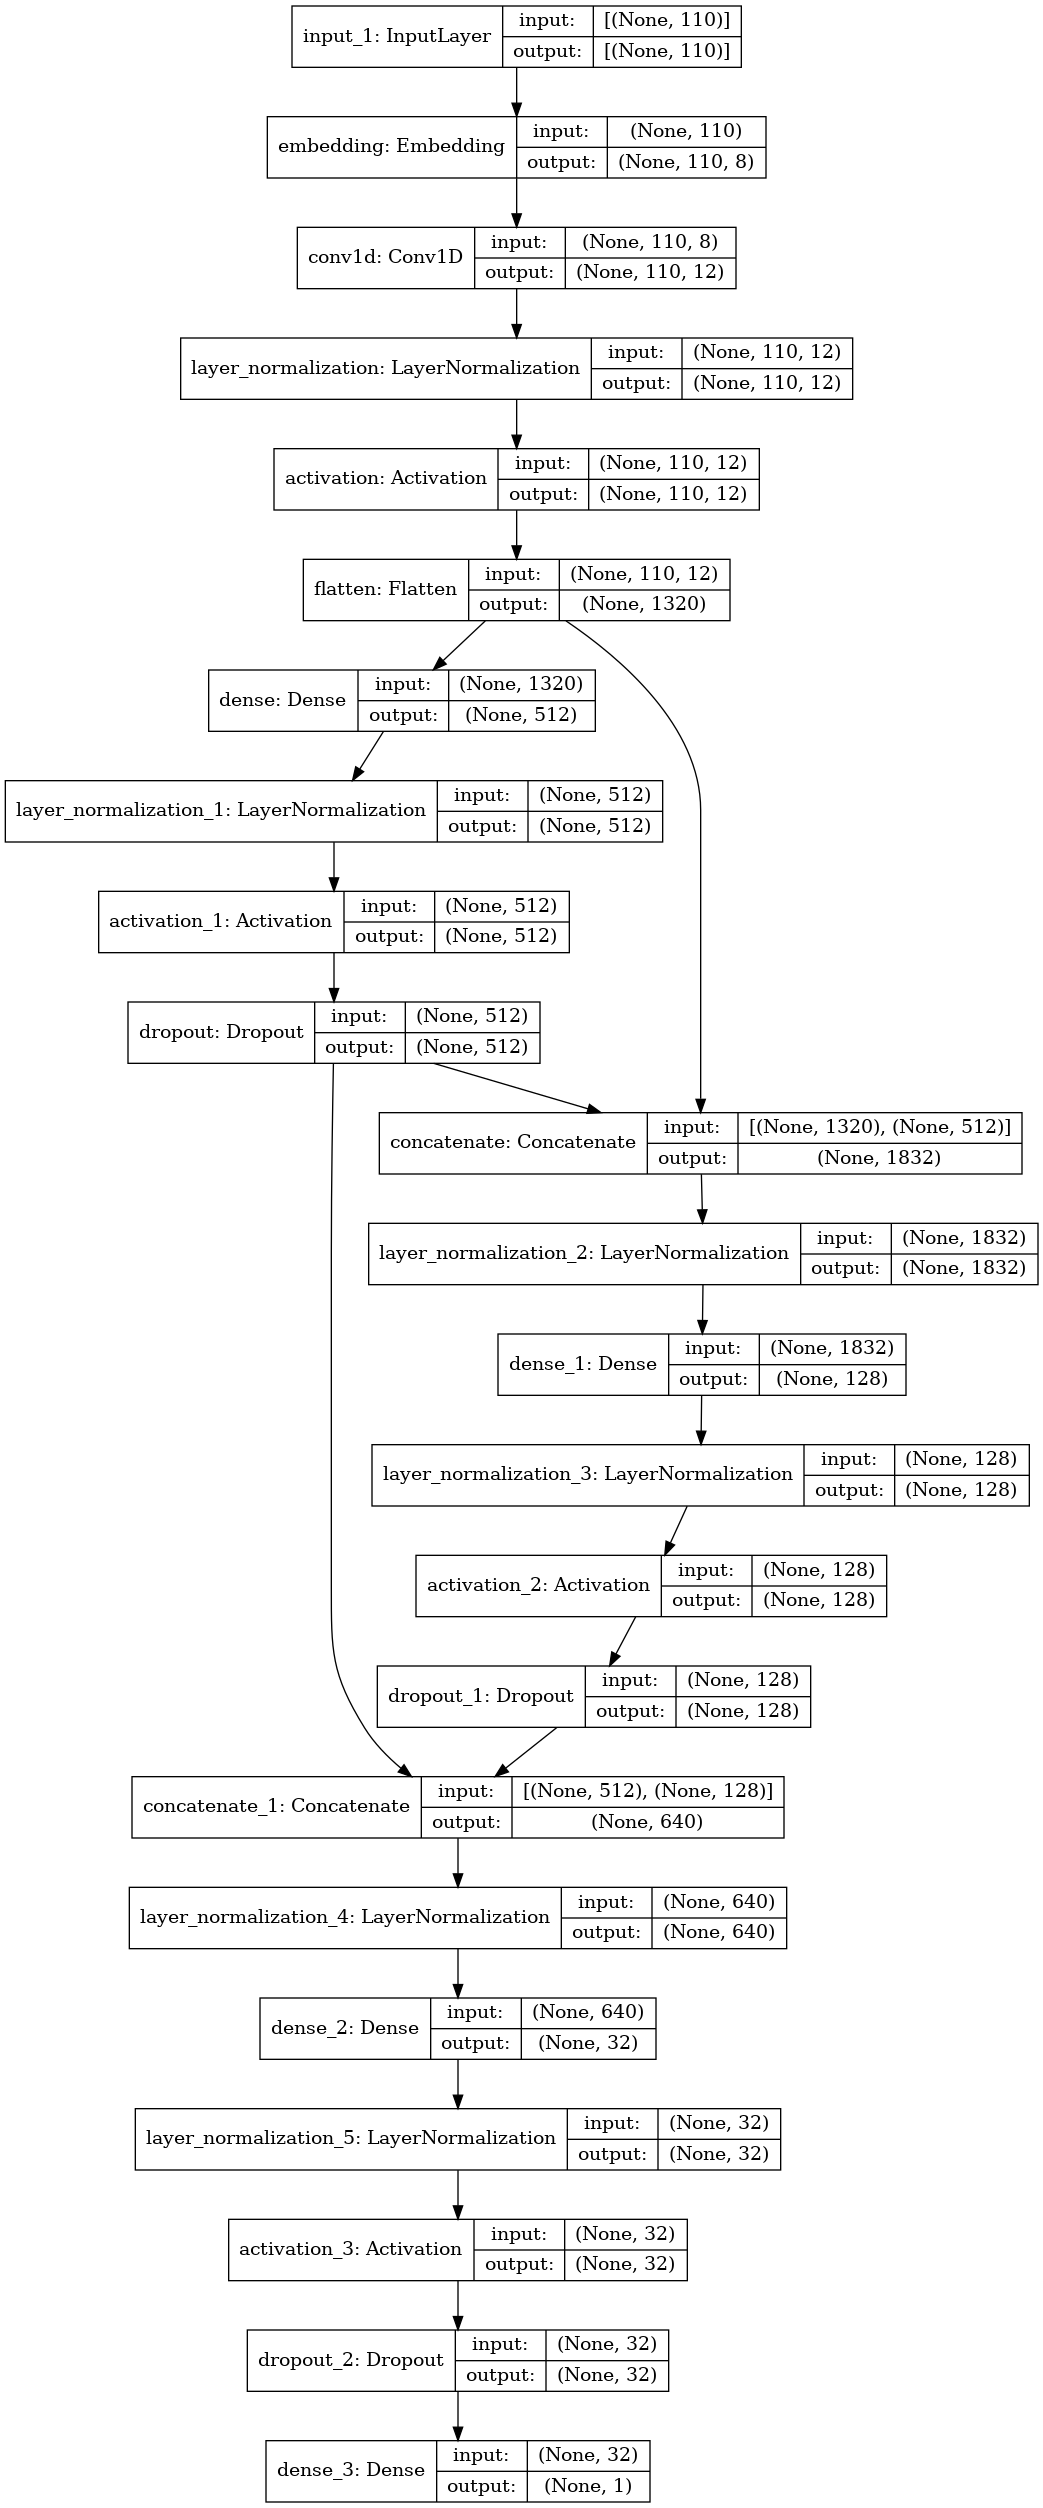

In [38]:
plot_model(
    model, 
    to_file='DareInReality_Keras_Model.png', 
    show_shapes=True,
    show_layer_names=True
)

In [39]:
FOLD = 5
VERBOSE = 0
BATCH_SIZE = 64
SEEDS = [1111, 2222]

counter = 0
oof_score = 0
y_pred_meta_dnn = np.zeros((Xtrain.shape[0], len(SEEDS)))
y_pred_final_dnn = np.zeros((test.shape[0], len(SEEDS)))


for sidx, seed in enumerate(SEEDS):
    seed_score = 0
    
    kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

    for idx, (train, val) in enumerate(kfold.split(Xtrain, Ytrain_strat)):
        counter += 1
        
        train_x, train_y = Xtrain.iloc[train], Ytrain.iloc[train]
        val_x, val_y = Xtrain.iloc[val], Ytrain.iloc[val]
        
        model = dnn_model(Xtrain.shape[1])
        model.compile(loss='mse', metrics=['msle'],
                      optimizer=Adam(learning_rate=1e-2))

        early = EarlyStopping(monitor="val_msle", mode="min", 
                              restore_best_weights=True, 
                              patience=15, verbose=VERBOSE)

        reduce_lr = ReduceLROnPlateau(monitor="val_msle", factor=0.25, 
                                      min_lr=1e-5, patience=4, 
                                      verbose=VERBOSE, mode='min')

        chk_point = ModelCheckpoint('./DNN_model.h5', 
                                    monitor='val_msle', verbose=VERBOSE, 
                                    save_best_only=True, mode='min')
        
        history = model.fit(
            train_x, train_y, 
            batch_size=BATCH_SIZE,
            epochs=100, 
            verbose=VERBOSE, 
            callbacks=[reduce_lr, early, chk_point], 
            validation_data=(val_x, val_y)
        )
        
        model = load_model('./DNN_model.h5')

        y_pred = model.predict(val_x, batch_size=BATCH_SIZE)
        y_pred_meta_dnn[val, sidx] += y_pred.ravel()
        y_pred_final_dnn[:, sidx] += model.predict(test, batch_size=BATCH_SIZE).ravel()
        
        score = np.sqrt(mean_squared_log_error(np.exp(val_y), np.exp(y_pred)))
        oof_score += score
        seed_score += score
        print("Seed-{} | Fold-{} | OOF Score: {}".format(seed, idx+1, score))
    
    print("\nSeed: {} | Aggregate OOF Score: {}\n\n".format(seed, (seed_score / FOLD)))


y_pred_final_dnn = y_pred_final_dnn / float(FOLD)
oof_score /= float(counter)
print("Aggregate OOF Score: {}".format(oof_score))

2021-11-22 12:33:21.982910: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Seed-1111 | Fold-1 | OOF Score: 0.5051945312926317
Seed-1111 | Fold-2 | OOF Score: 0.5195365504074744
Seed-1111 | Fold-3 | OOF Score: 0.489374652319282
Seed-1111 | Fold-4 | OOF Score: 0.5098374847085618
Seed-1111 | Fold-5 | OOF Score: 0.5272951769389703

Seed: 1111 | Aggregate OOF Score: 0.5102476791333841


Seed-2222 | Fold-1 | OOF Score: 0.5279489348804098
Seed-2222 | Fold-2 | OOF Score: 0.49980050381515556
Seed-2222 | Fold-3 | OOF Score: 0.5013202724593423
Seed-2222 | Fold-4 | OOF Score: 0.5248481303399686
Seed-2222 | Fold-5 | OOF Score: 0.46028025060753813

Seed: 2222 | Aggregate OOF Score: 0.5028396184204829


Aggregate OOF Score: 0.5065436487769335


In [40]:
np.savez_compressed('./Meta_Features.npz',
                    y_pred_meta_dnn=y_pred_meta_dnn,
                    y_pred_final_dnn=y_pred_final_dnn)

## Create submission files

In [41]:
submit_df = pd.DataFrame()
submit_df['LAP_TIME'] = np.expm1(np.mean(y_pred_final_dnn, axis=1))
submit_df.to_csv("./dnn_submission.csv", index=False)
submit_df.head()

,LAP_TIME
0,81.815208
1,81.701904
2,81.760466
3,81.815208
4,81.701904


In [42]:
submit_df = pd.DataFrame()
submit_df['LAP_TIME'] = np.expm1(np.mean(y_pred_final_dnn, axis=1))
submit_df["LAP_TIME"] = np.round((submit_df.LAP_TIME - P_MIN)/P_STEP) * P_STEP + P_MIN
submit_df["LAP_TIME"] = np.clip(submit_df.LAP_TIME, P_MIN, P_MAX)
submit_df.to_csv("./dnn_submission_post_process.csv", index=False)
submit_df.head()

,LAP_TIME
0,80.0
1,80.0
2,80.0
3,80.0
4,80.0
